# Universidad de Buenos Aires
# Computer Vision - Examen
Análisis de cultivos en imagenes satelitales



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as k
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from skimage.io import imread
import numpy as np
from random import sample
from keras.utils import to_categorical
import os
from glob import glob
from google.colab import drive
import pandas as pd

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP")

## Funciones Helpers

In [ ]:
def preprocessing_image_ms(x, mean, std):
    # loop over image channels
    for idx, mean_value in enumerate(mean):
        x[..., idx] -= mean_value
        x[..., idx] /= std[idx]
    return x


def categorical_label_from_full_file_name(files, class_indices):
  
    # file basename without extension
    base_name = [os.path.splitext(os.path.basename(i))[0] for i in files]
    # class label from filename
    base_name = [i.split("_")[0] for i in base_name]
    # label to indices
    image_class = [class_indices[i] for i in base_name]
    # class indices to one-hot-label
    return to_categorical(image_class, num_classes=len(class_indices))

def hyperspectral_image_generator(files, class_indices, batch_size=32, image_mean=None,
                           rotation_range=0, shear_range=0, scale_range=1,
                           transform_range=0, horizontal_flip=False,
                           vertical_flip=False, crop=False, crop_size=None, filling_mode='edge',
                           speckle_noise=None):
    

    while True:
        # select batch_size number of samples without replacement
        batch_files = sample(files, batch_size)
        # get one_hot_label
        batch_Y = categorical_label_from_full_file_name(batch_files,
                                                        class_indices)
        # array for images
        batch_X = []
        # loop over images of the current batch
        for idx, input_path in enumerate(batch_files):
            normalization_factor =  0.0001
            image = np.array(imread(input_path), dtype=np.int16)
            image = image * normalization_factor
            
            # Imprime las imagenes que esta analizando
            # print(input_path, image.shape, image.max())
            
            if image_mean is not None:
                mean_std_data = np.loadtxt(image_mean, delimiter=',')
                image = preprocessing_image_ms(image, mean_std_data[0], mean_std_data[1])
            # process image
           
            # put all together
            batch_X += [image]
        # convert lists to np.array
        X = np.array(batch_X)
        Y = np.array(batch_Y)
       
        yield(X, Y)



## CNN

In [ ]:
class2dir = {
            'M':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h' ,
            'S':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h' ,
            's':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h' ,
            'N':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h' ,
            'P':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h' ,
            'A':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'B':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'm':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'U':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'T':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'G':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'aa':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h' ,
            'R':'/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h'
}

In [ ]:
classes_files = {}
for k, v in class2dir.items():
    classes_files[k] = [glob(v + f"/{k}/*.tif"), 0, 0]
    print("clase", k, ",cantidad:", len(classes_files[k][0]))

clase M ,cantidad: 208
clase S ,cantidad: 340
clase s ,cantidad: 87
clase N ,cantidad: 66
clase P ,cantidad: 54
clase A ,cantidad: 70
clase B ,cantidad: 104
clase m ,cantidad: 86
clase U ,cantidad: 49
clase T ,cantidad: 100
clase G ,cantidad: 40
clase aa ,cantidad: 24
clase R ,cantidad: 92


In [ ]:
# Aumentar datos
folder_imagenes_rotadas = '/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_rotadas'
for k, v in class2dir.items():
    archivos_originales = classes_files[k][0]
    archivos_rotados = glob(folder_imagenes_rotadas + f"/{k}/*.tif")
    classes_files[k][0] = archivos_originales + archivos_rotados
    print("clase", k, ",cantidad:", len(classes_files[k][0]))

clase M ,cantidad: 832
clase S ,cantidad: 1360
clase s ,cantidad: 348
clase N ,cantidad: 264
clase P ,cantidad: 216
clase A ,cantidad: 280
clase B ,cantidad: 416
clase m ,cantidad: 344
clase U ,cantidad: 196
clase T ,cantidad: 400
clase G ,cantidad: 160
clase aa ,cantidad: 96
clase R ,cantidad: 368


In [ ]:
# Acotar la cantidad de samples por clase
max_sample = 400
for k, v in class2dir.items():
    classes_files[k][0] = classes_files[k][0][:(max_sample)]
    print("clase", k, ",cantidad:", len(classes_files[k][0]))

clase M ,cantidad: 400
clase S ,cantidad: 400
clase s ,cantidad: 348
clase N ,cantidad: 264
clase P ,cantidad: 216
clase A ,cantidad: 280
clase B ,cantidad: 400
clase m ,cantidad: 344
clase U ,cantidad: 196
clase T ,cantidad: 400
clase G ,cantidad: 160
clase aa ,cantidad: 96
clase R ,cantidad: 368


In [ ]:
def files_train_validation_split(files, validation_size=0.2):
    n_samples = len(files)
    indexes = np.random.permutation(np.arange(0, n_samples))
    train_idx = indexes[0:int((1-validation_size)*n_samples)]
    validation_idx = indexes[int((1-validation_size)*n_samples):]
    assert n_samples == train_idx.size + validation_idx.size

    # Train
    train_files = [files[i] for i in train_idx]

    # Validation
    validation_files = [files[i] for i in validation_idx]
    return train_files, validation_files

In [ ]:
for k, v in classes_files.items():
    train, valid = files_train_validation_split(v[0], validation_size=0.1)
    classes_files[k][1] = train
    classes_files[k][2] = valid
    print("clase", k, ",cantidad:", len(classes_files[k][0]), "train:",len(classes_files[k][1]), "valid:",len(classes_files[k][2]))

clase M ,cantidad: 400 train: 360 valid: 40
clase S ,cantidad: 400 train: 360 valid: 40
clase s ,cantidad: 348 train: 313 valid: 35
clase N ,cantidad: 264 train: 237 valid: 27
clase P ,cantidad: 216 train: 194 valid: 22
clase A ,cantidad: 280 train: 252 valid: 28
clase B ,cantidad: 400 train: 360 valid: 40
clase m ,cantidad: 344 train: 309 valid: 35
clase U ,cantidad: 196 train: 176 valid: 20
clase T ,cantidad: 400 train: 360 valid: 40
clase G ,cantidad: 160 train: 144 valid: 16
clase aa ,cantidad: 96 train: 86 valid: 10
clase R ,cantidad: 368 train: 331 valid: 37


In [ ]:
files_train = []
files_val = []
for k, v in classes_files.items():
    files_train = files_train + v[1]
    files_val = files_val + v[2]
print("train size:", len(files_train), "valid size:", len(files_val))

train size: 3482 valid size: 390


In [ ]:
# # Carpeta del drive donde estan las imagenes
# folderPath1 = '/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_h'
# folderPath2 = '/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_v5_h'

# files1 = np.random.permutation(glob(folderPath1 + "/**/*.tif"))
# files2 = np.random.permutation(glob(folderPath2 + "/**/*.tif"))

# files = np.concatenate((files1, files2), axis=0)


# train_validation_split_index = np.ceil((len(files) * 0.7)).astype(int)

# files_train = files[0: train_validation_split_index]
# files_val = files[train_validation_split_index:]

print("cantidad de muestras:", len(files_train)+len(files_val))

BATCH_SIZE = 60
FILES_AMOUNT = len(files_train)

BATCH_SIZE_VALID = 39
FILES_AMOUNT_VALID = len(files_val)


image_class = [f.split('/')[-1].split("_")[0] for f in files_train]
classes = {}
weight_clases = {}
num2classes = {}
for i,c in enumerate(np.unique(image_class)):
  classes[c]=i
  num2classes[i] = c
  weight_clases[c]= np.sum(1 if ("/" + c + '/') in f else 0 for f in files_train)



train_generator = hyperspectral_image_generator(
    files_train,
    class_indices = classes,
    batch_size=BATCH_SIZE
)


val_generator = hyperspectral_image_generator(
    files_val,
    class_indices = classes,
    batch_size=BATCH_SIZE_VALID
)


CLASSES_COUNT = len(classes)

weight_clases


cantidad de muestras: 3872


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


{'A': 252,
 'B': 360,
 'G': 144,
 'M': 360,
 'N': 237,
 'P': 194,
 'R': 331,
 'S': 360,
 'T': 360,
 'U': 176,
 'aa': 86,
 'm': 309,
 's': 313}

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy
model = models.Sequential()

model.add(layers.Conv2D(64, (3,3), activation='relu', padding ='same',input_shape=(16,16,13)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3),  padding ='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3),  padding ='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(CLASSES_COUNT, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=[ CategoricalAccuracy(name="accuracy")] )

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        7552      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

In [ ]:
history = model.fit_generator(
            train_generator,
            epochs=200,
            steps_per_epoch=FILES_AMOUNT/BATCH_SIZE,
            validation_data=val_generator,
            validation_steps=FILES_AMOUNT_VALID/BATCH_SIZE_VALID
          )

Epoch 1/100
59/58 [==============================] - 10s 173ms/step - loss: 0.3765 - accuracy: 0.8650 - val_loss: 0.3487 - val_accuracy: 0.8897
Epoch 2/100
59/58 [==============================] - 10s 172ms/step - loss: 0.3550 - accuracy: 0.8667 - val_loss: 0.3650 - val_accuracy: 0.8513
Epoch 3/100
59/58 [==============================] - 10s 170ms/step - loss: 0.3781 - accuracy: 0.8636 - val_loss: 0.4303 - val_accuracy: 0.8231
Epoch 4/100
59/58 [==============================] - 10s 170ms/step - loss: 0.3667 - accuracy: 0.8613 - val_loss: 0.3973 - val_accuracy: 0.8769
Epoch 5/100
59/58 [==============================] - 10s 169ms/step - loss: 0.3558 - accuracy: 0.8723 - val_loss: 0.3817 - val_accuracy: 0.8974
Epoch 6/100
59/58 [==============================] - 10s 170ms/step - loss: 0.3769 - accuracy: 0.8689 - val_loss: 0.3785 - val_accuracy: 0.8795
Epoch 7/100
59/58 [==============================] - 10s 170ms/step - loss: 0.3723 - accuracy: 0.8653 - val_loss: 0.4356 - val_accuracy:

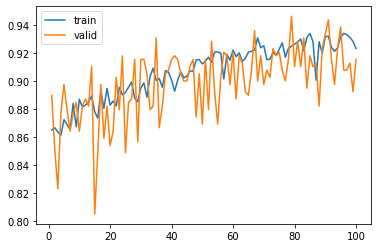

In [ ]:
import seaborn as sns
epoch_count = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
test_generator = hyperspectral_image_generator(
    files_val,
    class_indices = classes,
    batch_size=1
)

In [ ]:
y_predict = model.predict_generator(test_generator,steps=len(files_val))

y_true = categorical_label_from_full_file_name(files_val,classes)



In [ ]:
y_true_index = [ i.argmax() for i in y_true]
y_predict_index = [ i.argmax() for i in y_predict]

from sklearn.metrics import accuracy_score, balanced_accuracy_score


score = balanced_accuracy_score(y_true_index, y_predict_index)

b = (( np.array(y_true_index) - np.array(y_predict_index)))
c =(b == 0).sum() /len(y_true_index)
print(c,score)

0.09487179487179487 0.089504077004077


Accuracy 0.09487179487179487
Balanced Accuracy 0.089504077004077


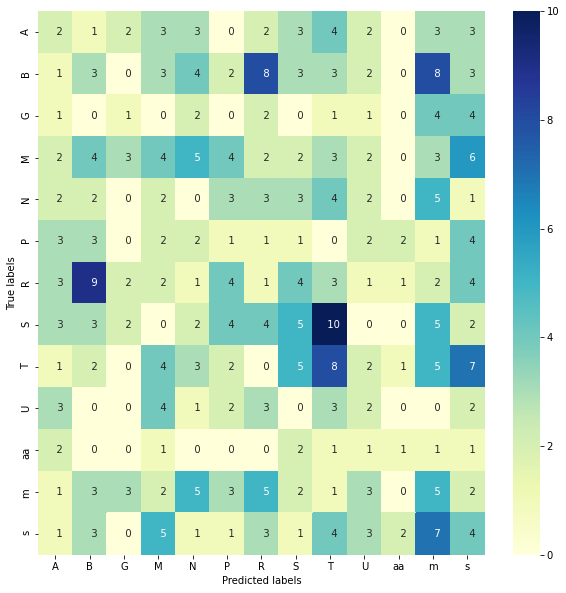

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

print("Accuracy", accuracy_score(y_true_index, y_predict_index))
print("Balanced Accuracy", balanced_accuracy_score(y_true_index, y_predict_index))
cm =confusion_matrix(y_true_index,y_predict_index)
   
f,ax= plt.subplots(1,figsize=(10,10))
sns.heatmap(
    cm, 
    annot=True,#annot=True to annotate cells
    ax = ax,
    cmap="YlGnBu",
    xticklabels=classes.keys(), 
    yticklabels=classes.keys(),
    fmt="4"); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

In [ ]:
model.save("model_v5.h5")

## Predict test

In [ ]:
import csv
import pandas as pd
testPath = '/content/drive/MyDrive/UBA IA 2020/8-VPC2/TP/imagenes_tp_test'

if os.access('Etiquetas.csv', os.F_OK) is False:
    !wget https://raw.githubusercontent.com/hernancontigiani/desafiosAgTech2020/main/Etiquetas.csv Etiquetas.csv
else:
    print("archivo ya descargado")
etiquetas = pd.read_csv("Etiquetas.csv")

files = glob(testPath + "/**/*.tif")

global_id = os.path.basename(files[0]).split("_")[1].split(".")[0]

resultados = []

for file in files:
    normalization_factor =  0.0001
    image = np.array(imread(file), dtype=np.int16)
    image = image * normalization_factor
    test_img = np.array([image])

    image_classes = model.predict(test_img).argmax()
    cultivo = num2classes[image_classes]
    cultivo_id = etiquetas.loc[etiquetas["Cultivo"] == cultivo, 'CultivoId'].item()

    global_id = os.path.basename(file).split("_")[1].split(".")[0]
    resultados.append({"GlobalId": global_id, "CultivoId": cultivo_id})

with open("submit_5c.csv", "w") as csvfile:
    header = ['GlobalId', 'CultivoId']
    # Crear el objeto para escribir las lineas de archivo
    # basado en los nombres de las columnas
    writer = csv.DictWriter(csvfile, fieldnames=header)
    
    for resultado in resultados:
        writer.writerow(resultado)

archivo ya descargado
